# OVERVIEW
In the National Football League, coaches employ a variety of guiding philosophies that they believe are superior, proven pathways to consistent success. These days, much attention has been directed at the explosive offenses of the Los Angeles Rams and the Kansas City Chiefs, two teams who score very quickly while also surrendering a lot of points on defense. Some pundits and NFL veterans argue that this is the future of the league.

However, one approach that is getting overlooked is the maximization of "offensive efficiency." For this analysis, we'll define "offensive efficiency" as:

> <i>"Scoring the most points possible while prolonging possession of the ball in order to limit the opponent's possession of the ball."</i>

Teams that are highly offensive efficient therefore demonstrate the following traits:

- More plays per drive
- More yards per drive
- Longer time of possession
- And obviously, more points per drive

Unlike the Rams and Chiefs, who often score touchdowns on a few large-yardage plays per drive, the 2018 New Orleans Saints rarely registered explosive plays that resulted in 40+ yards gained. Most of their plays were for short and intermediate yard gains that sustained drives that ultimately ended in a score. We'll explore how these metrics of offensive efficiency differ among good teams (12+ regular season wins), OK teams (7 to 11 wins), and bad teams (<7 wins), and whether any trends have emerged over time.

## Comfortable Lead and Offensive Efficiency
We'll also look at teams of the aforementioned tiers perform once they've established a comfortable lead of 20+ points. Once a team establishes a comfortable lead, they are expected to employ a strategy of "draining the clock" by calling more plays that are likely to prevent a play clock stoppage at the conclusion of the play. This is thus time for the leading team to demonstrate greater offensive efficiency.

By draining the clock and "slowing down the game", the team with the comfortable lead:

- Sustains longer offensive drives
- Makes the trailing team's defense tired, as the unit is on the field longer
- Limits the time the trailing team can play on offense
- Allows its defense to rest and remain 'fresh' for when it must take the field

# DATA EXPLORATION

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import re
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('NFL Play by Play 2009-2018 (v5).csv', low_memory=False)

## Selecting Relevant Features

In [2]:
data_columns = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam',
       'posteam_type', 'game_date', 'game_seconds_remaining', 'game_half',
       'drive', 'qtr', 'down', 'desc', 'play_type', 'yards_gained', 'timeout',
       'total_home_score', 'total_away_score', 'posteam_score',
       'defteam_score', 'score_differential', 'posteam_score_post',
       'defteam_score_post', 'score_differential_post', 'third_down_converted',
       'fourth_down_converted', 'incomplete_pass', 'interception', 'penalty',
       'penalty_team', 'penalty_player_id', 'penalty_player_name',
       'penalty_yards', 'replay_or_challenge_result', 'penalty_type']

data = data[data_columns]

In [3]:
end_of_game = data[data['desc'] == 'END GAME']
print(end_of_game.shape)

# end_of_game.shape shows that only 2104 games contain the 'END GAME' value.
end_of_game = data.sort_values('play_id').groupby('game_id').tail(1)

# This was the final game played in Week 15, meaning there were 32 games left to be played in the 2018 season
#  (16 each in Weeks 16 and 17). 2,560 (10 complete seasons) - 2,526 = 34. This suggests that the dataset is missing 2 games.
end_of_game.shape

(2104, 35)


(2526, 35)

# FEATURE CLEANING

To more fully test our hypothesis, we need to create several new features that are currently not captured in the dataset. We'd like to know the following for each team on a cumulative (not per-play) basis:

- The number of run plays called
- The number of pass plays called
- The number of "chunk yardage" plays (plays that result in yardage gains of 10 to 25 yards)
- Time of possession

## Yardage Clean-up

In [4]:
# `yards_gained` is yards accrued on each play for the offensive team.
print(data['yards_gained'].isnull().sum())
print(len(data))

213
449371


In [5]:
# Each `desc` string contains numerous numbers referring to time, yards, penalty yards, and other figures.
# Should first pull all "# yard(s)" references specifically before converting them to numeric values.
data['desc_yards'] = data['desc'].str.extract('(-?\d+\syards?)')
data['desc_yards'].head(20)

0      67 yards
1       5 yards
2      -3 yards
3           NaN
4      54 yards
5           NaN
6       4 yards
7      -2 yards
8      50 yards
9       3 yards
10     10 yards
11     -1 yards
12      9 yards
13    -19 yards
14     30 yards
15     32 yards
16     20 yards
17      3 yards
18          NaN
19          NaN
Name: desc_yards, dtype: object

In [6]:
print(data.loc[3,'desc'])
print(data.loc[5,'desc'])
print(data.loc[18,'desc'])
print(data.loc[19,'desc'])
# Null values in the `desc_yards` column can be converted to zero yards. Will do later.

(13:35) (Shotgun) B.Roethlisberger pass incomplete deep right to M.Wallace. COVERAGE BY #24 HOPE
(13:16) C.Johnson up the middle to TEN 2 for no gain (B.Keisel, J.Farrior).
(6:57) K.Collins pass incomplete short right to A.Crumpler. Coverage by #56 Woodley, #22 Gay.
(6:52) (Shotgun) K.Collins pass incomplete short right to B.Scaife (T.Polamalu).


In [7]:
#  Creates a column that pulls the numeric yardage value from `desc_yards`.
data['yards_clean'] = data['desc_yards'].str.extract('(-?\d+)').astype(float)
no_gain = data[data['desc'].str.contains("no gain", na=False)]
no_gain.tail()

,play_id,game_id,home_team,away_team,posteam,posteam_type,game_date,game_seconds_remaining,game_half,drive,...,interception,penalty,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge_result,penalty_type,desc_yards,yards_clean
449185,4369,2018121611,LA,PHI,PHI,away,2018-12-16,183.0,Half2,22,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,52 yards,52.0
449220,449,2018121700,CAR,NO,CAR,home,2018-12-17,3146.0,Half1,3,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449293,2210,2018121700,CAR,NO,NO,away,2018-12-17,1712.0,Half2,13,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449303,2490,2018121700,CAR,NO,NO,away,2018-12-17,1563.0,Half2,15,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449318,2861,2018121700,CAR,NO,CAR,home,2018-12-17,1115.0,Half2,16,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22 yards,22.0


In [8]:
print(data.loc[449318,'desc'])
print(data.loc[449318,'yards_clean'])
# CAR is correctly credited with a 22-yard gain before DJ Moore fumbled the ball.

(3:35) D.Moore up the middle to NO 28 for 22 yards (V.Bell). FUMBLES (V.Bell), RECOVERED by NO-A.Klein at NO 16. A.Klein to NO 16 for no gain (C.Samuel).
22.0


## Non-offensive Plays

In [9]:
# Place kicks and punts have a `desc` string that references "# yards" that should not count toward total offensive yards.
play_type_filters = ['punt', 'no_play', 'kickoff', 'extra_point', 'field_goal']

for ptf in play_type_filters:
    data.loc[data['play_type'] == ptf, 'yards_clean'] = 0

## Incomplete Passes

In [10]:
data[(data['incomplete_pass'] == 1) & (data['yards_clean']>0)][['game_id','desc']].head(10)

,game_id,desc
488,2009091307,(2:19) M.Stafford pass short left to B.Johnson...
2634,2009091401,(:50) (Shotgun) J.Russell pass deep middle to ...
2761,2009092000,(7:42) (Shotgun) M.Ryan pass short middle to R...
2855,2009092000,(5:41) J.Delhomme pass short right to J.King t...
3729,2009092005,(8:38) M.Sanchez pass short right to C.Stuckey...
5330,2009092014,(:12) (Shotgun) T.Romo pass incomplete deep le...
5499,2009092100,"(:14) (No Huddle, Shotgun) P.Manning pass shor..."
7893,2009092712,"(:05) (No Huddle, Shotgun) J.Russell pass deep..."
8279,2009092800,(12:15) T.Romo pass incomplete short left to R...
8280,2009092800,(12:11) T.Romo pass incomplete short left to M...


In [11]:
print(data.loc[488,'desc'])
print(data.loc[5160,'desc'])

(2:19) M.Stafford pass short left to B.Johnson ran ob at DET 46 for 11 yards. New Orleans challenged the pass completion ruling, and the play was REVERSED. M.Stafford pass incomplete short left to B.Johnson.
(13:14) (Shotgun) J.Cutler pass incomplete short right to D.Hester [N.Eason]. PENALTY on CHI-J.Cutler, Intentional Grounding, 10 yards, enforced at CHI 37.


Positive-yardage plays that are negated via successful challenges and penalties are incorrectly generating yardage gains in `yards_clean`.

## Plays Reversed by Successful Challenges

In [12]:
data.loc[data.replay_or_challenge_result=='reversed', 'yards_clean'] = data['yards_gained']

## Interceptions

In [13]:
print(data[data['interception'] == 1]['yards_clean'].head())
print()
print(data.loc[31,'desc'])
print(data.loc[89,'desc'])

31     16.0
34      NaN
89     80.0
272     NaN
404    26.0
Name: yards_clean, dtype: float64

(1:51) K.Collins pass deep left intended for K.Britt INTERCEPTED by T.Polamalu at PIT 5. T.Polamalu to PIT 21 for 16 yards (A.Hall).
(:01) (Shotgun) B.Roethlisberger pass deep middle intended for M.Wallace INTERCEPTED by C.Finnegan at TEN 0. C.Finnegan to PIT 20 for 80 yards (M.Starks; H.Miller).


In [14]:
# The yardage gains on these interceptions are being credited to the offensive team, but they should refer to the yards
# accrued by the intercepting defender.
pass_plays = ['incomplete_pass','interception']

for play in pass_plays:
    data.loc[data[play] == 1, 'yards_clean'] = 0

## Penalties

In [15]:
# Cleaning up yardage gains that are nullified by penalties.

penalties = ['False Start', 'Defensive Pass Interference', 'Defensive Holding',
             'Defensive Offside', 'Delay of Game', 'Illegal Block Above the Waist',
             'Neutral Zone Infraction', 'Roughing the Passer', 'Illegal Use of Hands',
             'Offensive Pass Interference', 'Illegal Contact', 'Encroachment', 'Illegal Formation',
             'Intentional Grounding', 'Illegal Shift', 'Offside on Free Kick', 'Horse Collar Tackle',
             'Ineligible Downfield Pass', 'Illegal Motion', 'Illegal Substitution', 'Chop Block',
             'Ineligible Downfield Kick', 'Player Out of Bounds on Punt', 'Tripping',
             'Running Into the Kicker', 'Illegal Forward Pass', 'Illegal Touch Kick',
             'Illegal Touch Pass', 'Illegal Blindside Block', 'Fair Catch Interference', 'Low Block',
             'Clipping', 'Roughing the Kicker', 'Disqualification', 'Offensive Offside',
             'Interference with Opportunity to Catch', 'Defensive Too Many Men on Field', 'Leverage',
             'Defensive Delay of Game', 'Illegal Crackback', 'Invalid Fair Catch Signal',
             'Leaping', 'Illegal Wedge', 'Illegal Bat', 'Player Out of Bounds on Kick',
             'Offensive Too Many Men on Field', 'Illegal Peelback', 'Kick Catch Interference',
             'Illegal Receiver Pass', 'Illegal Kick', 'Short Free Kick', 'Kickoff Out of Bounds',
             'Delay of Kickoff', 'Illegal Onside Kick', 'Illegal Cut', 'Illegally Kicking Ball',
             'Illegal Procedure']

for penalty in penalties:
    data.loc[(data['penalty_team'] == data['posteam']) & 
             (data['penalty_type']==penalty), 'yards_clean'] = 0

## Offensive Holding

In [16]:
# Positive yards and a holding call --> 10-yard penalty from spot of foul.
# Zero or negative yards and a holding call --> 10-yard penalty from line of scrimmage.

data.loc[(data['penalty_team'] == data['posteam']) & (data['penalty_type']=='Offensive Holding') & 
         (data['yards_gained'] < 0), 'yards_clean'] = 0

data.loc[data['yards_clean'].isnull(), 'yards_clean'] = 0

## Team Name Changes

In [17]:
# All columns in the dataframe that contain a team abbreviation.
team_types = ['home_team', 'away_team', 'posteam', 'penalty_team']

for tt in team_types:
    data.loc[data[tt] == 'STL', tt] = 'LA'
    data.loc[data[tt] == 'SD', tt] = 'LAC'
    data.loc[data[tt] == 'JAC', tt] = 'JAX'

## Timeouts

In [18]:
# Eliminates all rows with a called timeout. The team that calls a timeout is designated as the `posteam`. This is inaccurate.
data = data[data.timeout != 1]

# FEATURE ENGINEERING

## Functions - Score, Plays

In [19]:
data.rename(columns={'total_home_score' : 'home_score_total'}, inplace=True)
data.rename(columns={'total_away_score' : 'away_score_total'}, inplace=True)

# Creates final scores for each game. The final score is displayed for each game, regardless of the play.
# For example, a game ending in a score of 27 to 10 will display these values in the row corresponding the opening kick-off,
# which is the first play of the game.
def process_score(df):
    types = ['home','away']
    for team in types:
        df[team + '_score_final'] = df[team + '_score_total'].groupby(df['game_id']).transform('max')
    df['score_diff'] = df[types[0] + '_score_total'] - df[types[1] + '_score_total']
# A comfortable lead is a lead greater than or equal to 20 points.
    df[types[0] + '_comfy_lead'] = np.where(df['score_diff']>= 20, 1, 0)
    df[types[1] + '_comfy_lead'] = np.where(df['score_diff']<= -20, 1, 0)
    return df

# Creates a new binary column that counts pass plays with 1s and 0s.
# Creates a new column that displays the final tally of pass plays for each game, regardless of the play.
def process_pass(df):
    types = ['home','away']
    for team in types:
        df[team + '_passes'] = np.where( ((df['posteam_type']==team) & (df['play_type']=='pass')), 1, 0)
        df[team + '_passes_final'] = df[team + '_passes'].groupby(df['game_id']).transform('sum')
    return df

# Creates a new binary column that counts run plays with 1s and 0s.
# Creates a new column that displays the final tally of run plays for each game, regardless of the play.
def process_run(df):
    types = ['home','away']
    for team in types:
        df[team + '_runs'] = np.where( (df['posteam_type']==team) & (df['play_type']=='run'), 1, 0)
        df[team + '_runs_final'] = df[team + '_runs'].groupby(df['game_id']).transform('sum')
    return df

# Creates a new column that counts offensive yards accrued per play.
# Creates a new column that displays the final tally of offensive yards for each game, regardless of the play.
# Creates a new column that displays the final tally of offensive yards for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final tally of offensive yards for each game, when the team did NOT have a comfy lead.
def process_yards(df):
    types = ['home','away']
    for team in types:
        df[team + '_yards'] = np.where( (df['posteam_type']==team), df['yards_clean'], 0)
        df[team + '_yards_final'] = df[team + '_yards'].groupby(df['game_id']).transform('sum')
        df[team + '_yards_wcl'] = np.where( (df['posteam_type']==team) & (df[team + '_comfy_lead']==1), df['yards_clean'], 0)
        df[team + '_yards_wcl_final'] = df[team + '_yards_wcl'].groupby(df['game_id']).transform('sum')
        df[team + '_yards_wcl_final'] = df.groupby(df['game_id'])[team + '_yards_wcl_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_yards_wcl_final'] = df.groupby(df['game_id'])[team + '_yards_wcl_final'].apply(lambda x: x.fillna(0))
        df[team + '_yards_wocl_final'] = df[team + '_yards_final'] - df[team + '_yards_wcl_final']
    return df

# Creates a new column that counts offensive plays.
# Creates a new column that displays the final tally of offensive plays for each game.
# Creates a new column that displays the final tally of offensive plays for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final tally of offensive plays for each game, when the team did NOT have a comfy lead.
def combined_plays(df):
    types = ['home','away']
    for team in types:
        df[team + '_combined_plays'] = np.where( (df['posteam_type']==team) & ((df['play_type']=='pass') | (df['play_type']=='run')), 1, 0)
        df[team + '_combined_plays_final'] = df[team + '_combined_plays'].groupby(df['game_id']).transform('sum')
        df[team + '_run_%_final'] = df[team + '_runs_final'] / df[team + '_combined_plays_final']
        df[team + '_combined_plays_wcl'] = np.where( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & 
                                                ( (df['play_type']=='run') | (df['play_type']=='pass') ), 1, 0)
        df[team + '_combined_plays_wcl_final'] = df[team + '_combined_plays_wcl'].groupby(df['game_id']).transform('sum')
        df[team + '_combined_plays_wcl_final'] = df.groupby(df['game_id'])[team + '_combined_plays_wcl_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_combined_plays_wcl_final'] = df.groupby(df['game_id'])[team + '_combined_plays_wcl_final'].apply(lambda x: x.fillna(0))
        df[team + '_combined_plays_wocl_final'] = df[team + '_combined_plays_final'] - df[team + '_combined_plays_wcl_final']
    return df

## Functions - Time of Possession, Drives

In [20]:
# Creates a new column that counts offensive drives (or team possessions of the ball).
# Creates a new column that displays the final tally of drives for each game.
# Creates a new column that displays the final tally of drives for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final tally of drives for each game, when the team did NOT have a comfy lead.

def process_drives(df):
    types = ['home','away']
    for team in types:
        df[team + '_drive_unique'] = df.where(df.posteam_type == team).groupby(['drive']).ngroup() + 1
        df[team + '_drives_final'] = df[df['posteam_type']==team].groupby(df['game_id'])['drive'].transform('nunique')
        df[team + '_drives_final'] = df.groupby(df['game_id'])[team + '_drives_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_drive_wcl'] = df.where( (df.posteam_type == team) & 
                                                 (df[team + '_comfy_lead'] == 1) ).groupby('drive').ngroup() + 1
        df[team + '_drives_wcl_final'] = df[(df['posteam_type']==team) &
                                          (df[team + '_comfy_lead']==1)].groupby(df['game_id'])['drive'].transform('nunique')
        df[team + '_drives_wcl_final'] = df.groupby(df['game_id'])[team + '_drives_wcl_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_drives_wcl_final'] = df.groupby(df['game_id'])[team + '_drives_wcl_final'].apply(lambda x: x.fillna(0))
        df[team + '_drives_wocl_final'] = df[team + '_drives_final'] - df[team + '_drives_wcl_final']
    return df

# Creates a new column that counts time of possession (TOP, how many game clock seconds the team controls the ball).
# Creates a new column that displays the final total TOP for each game.
# Creates a new column that displays the final total TOP for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final total TOP for each game, when the team did NOT have a comfy lead.
def process_TOP(df):
    types = ['home','away']
    for team in types:
        df[team + '_TOP'] = np.where( ( (df['posteam_type']==team) & (df['qtr']<5) ) |
                                ( (df['posteam_type']==team) & (df['qtr']==5) & 
                                 (df['game_seconds_remaining'].shift(1) >= df['game_seconds_remaining']) ), 
                                df.groupby(df['game_id']).game_seconds_remaining.diff().astype(float)*(-1), 0)
        df[team + '_TOP_final'] = df[team + '_TOP'].groupby(df['game_id']).transform('sum')
        
        df[team + '_TOP_wcl'] = np.where( ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & (df['qtr']<5) ) |
                                ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & (df['qtr']==5) & 
                                 (df['game_seconds_remaining'].shift(1) >= df['game_seconds_remaining']) ), 
                                df.groupby(df['game_id']).game_seconds_remaining.diff().astype(float)*(-1), 0)
        df[team + '_TOP_wcl_final'] = df[team + '_TOP_wcl'].groupby(df['game_id']).transform('sum')
        df[team + '_TOP_wocl'] = np.where( ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 0) & (df['qtr']<5) ) |
                                ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & (df['qtr']==5) & 
                                 (df['game_seconds_remaining'].shift(1) >= df['game_seconds_remaining']) ), 
                                df.groupby(df['game_id']).game_seconds_remaining.diff().astype(float)*(-1), 0)
        df[team + '_TOP_wocl_final'] = df[team + '_TOP_wocl'].groupby(df['game_id']).transform('sum')
    return df

pd.set_option('display.max_rows', 500)

## Function Run

In [21]:
data = process_score(data)
data = process_pass(data)
data = process_run(data)
data = process_yards(data)
data = combined_plays(data)
data = process_drives(data)
data = process_TOP(data)

## Functions - Wins

In [22]:
data['game_winner'] = np.where(data['home_score_final'] > data['away_score_final'], data['home_team'],
                             np.where(data['home_score_final'] < data['away_score_final'], data['away_team'], 'Tie'))
def process_game_winner(df):
    types = ['home','away']
    for team in types:
        data[team + '_gw'] = np.where( data['game_winner']==data[team + '_team'],1,0)
    return df

data = process_game_winner(data)

## Team Strata
In the years available in this dataset, no team that's recorded 11 regular season wins has failed to reach the playoffs. We will therefore consider teams that reach this threshold "good teams." While teams that win fewer games have made the playoffs, they have generally been plagued by execution issues, coaching incompetence, injuries, and off-field distractions that render them inconsistent. We'll split the teams into tiers as follows:

- Good Teams: 12+ regular season wins
- OK Teams: 7 to 10 regular season wins
- Bad Teams: 0 to 6 regular season wins

In [23]:
# Creates a season column, which is effectively the year the regular season started.
data['season'] = data['game_id'].astype(str).str[:4]
data['season'] = data['season'].astype(int)

# Designates early January regular season games as part of the season corresponding to the previous calendar year.
# For example, a January 1st, 2017 game should be designated as part of the 2016 season, not the 2017 season.
data.loc[data['game_date'].astype(str).str[5:7]==
         '01','season'] = data.loc[data['game_date'].astype(str).str[5:7]=='01','season'] - 1

# Since we will rely on final total values, we can limit each game_id to just one row each.
EOG = data.sort_values('play_id').groupby('game_id').apply(lambda x : x.index[-1])
data['EOG'] = 0
data.loc[EOG, 'EOG'] = 1

data['team_season_wins'] = data.groupby(['season','game_winner'])['EOG'].transform('sum')

# Breaks down the teams into performance tiers.
data['good_team'] = np.where( data.team_season_wins >= 12, 1, 0)
data['ok_team'] = np.where( (data.team_season_wins <= 11) & (data.team_season_wins >= 7), 1, 0)
data['bad_team'] = np.where( data.team_season_wins <= 6, 1, 0)

# NEW DATAFRAME

In [24]:
features = ['season', 'play_id', 'game_id', 'home_team', 'away_team', 'posteam',
            'posteam_type', 'desc',
            'home_score_total', 'away_score_total', 'score_diff', 'home_comfy_lead','away_comfy_lead',
            'home_score_final', 'away_score_final', 'EOG','game_winner',
            'home_gw', 'away_gw','team_season_wins','good_team', 'ok_team', 'bad_team',
            'yards_clean',
            'home_yards_final', 'home_yards_wcl_final', 'home_yards_wocl_final',
            'away_yards_final', 'away_yards_wcl_final', 'away_yards_wocl_final',
            'home_passes', 'away_passes', 'home_runs', 'away_runs',
            'home_combined_plays', 'home_combined_plays_final',
            'home_combined_plays_wcl_final','home_combined_plays_wocl_final','home_run_%_final',
            'away_combined_plays', 'away_combined_plays_final',
            'away_combined_plays_wcl_final','away_combined_plays_wocl_final', 'away_run_%_final',
            'drive',
            'home_drive_unique','home_drives_final','home_drives_wcl_final', 'home_drives_wocl_final',
            'away_drive_unique','away_drives_final', 'away_drives_wcl_final', 'away_drives_wocl_final',
            'home_TOP','home_TOP_final', 'home_TOP_wcl_final', 'home_TOP_wocl_final',
            'away_TOP','away_TOP_final', 'away_TOP_wcl_final', 'away_TOP_wocl_final'
            ]

nfl = data[features]

pd.set_option('display.max_columns', 100)

## Game Result and Season Wins Errors

In [25]:
nfl.loc[nfl['game_id']==2010092700, 'game_winner'] = 'CHI'
nfl.loc[nfl['game_id']==2010122500, 'game_winner'] = 'ARI'
nfl.loc[nfl['game_id']==2013120806, 'game_winner'] = 'MIA'
nfl.loc[nfl['game_id']==2013122900, 'game_winner'] = 'CAR'
nfl.loc[nfl['game_id']==2014113004, 'game_winner'] = 'JAX'
nfl.loc[nfl['game_id']==2015120602, 'game_winner'] = 'MIA'
nfl.loc[nfl['game_id']==2016120400, 'game_winner'] = 'KC'
nfl.loc[nfl['game_id']==2016111303, 'game_winner'] = 'DEN'
nfl.loc[nfl['game_id']==2017010109, 'game_winner'] = 'TB'
nfl.loc[nfl['game_id']==2017102902, 'game_winner'] = 'CIN'


nfl.loc[(nfl.game_winner == 'NYG') & (nfl.season==2012), 'team_season_wins'] = 9
nfl.loc[(nfl.game_winner == 'NYG') & (nfl.season==2016), 'team_season_wins'] = 11

# VISUALIZATIONS

In [26]:
# Team strata Boolean filters
good = nfl[(nfl['good_team']==1) & (nfl['season']<2019)][features]
ok = nfl[(nfl['ok_team']==1) & (nfl['season']<2019)][features]
bad = nfl[(nfl['bad_team']==1) & (nfl['season']<2019)][features]

## Running Plays

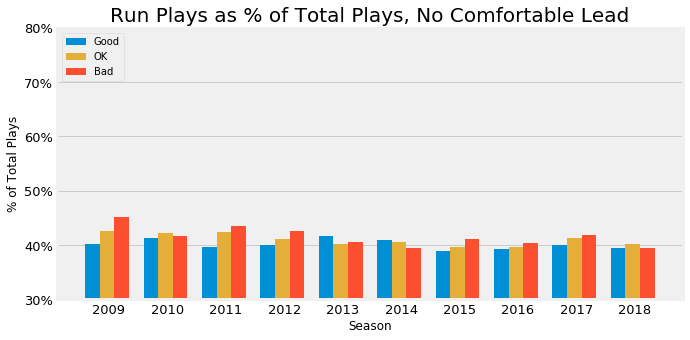

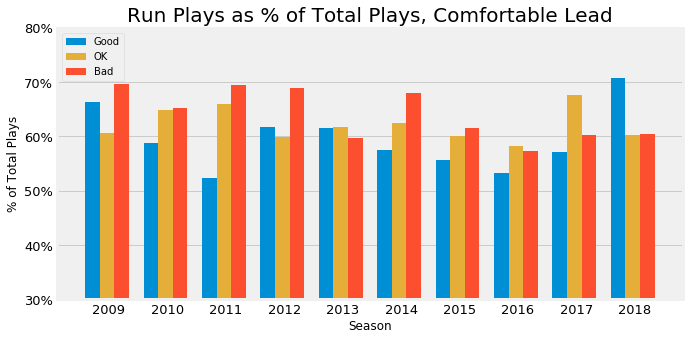

In [27]:
# Ommitting 2018 because we do not have a full season's worth of data for it.
seasons = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# Run plays as % of total plays general formula
def run_play_breakdown(df, comfy_lead):
    team_list = []
    for season in seasons:
        home_runs = df.loc[(df.season == season) & (df.home_comfy_lead == comfy_lead), 'home_runs'].sum()
        away_runs = df.loc[(df.season == season) & (df.away_comfy_lead == comfy_lead), 'away_runs'].sum()
        home_passes = df.loc[(df.season == season) & (df.home_comfy_lead == comfy_lead), 'home_passes'].sum()
        away_passes = df.loc[(df.season == season) & (df.away_comfy_lead == comfy_lead), 'away_passes'].sum()
        total_runs = home_runs + away_runs
        total_plays = home_runs + away_runs + home_passes + away_passes
        total_run_perc = total_runs / total_plays * 100
        team_list.append(total_run_perc)
    return team_list


graphs = ['runs_no_cl', 'runs_cl']
titles = ['Run Plays as % of Total Plays, No Comfortable Lead', 'Run Plays as % of Total Plays, Comfortable Lead']

for i in range(2):
    good_teams = run_play_breakdown(good, i)
    ok_teams = run_play_breakdown(ok, i)
    bad_teams = run_play_breakdown(bad, i)

    df = pd.DataFrame(
        {
            "Season": seasons,
            "Good": good_teams,
            "OK": ok_teams,
            "Bad": bad_teams
        })

    fig, graphs[i] = plt.subplots(figsize=(10,5))
    graphs[i].bar(df.Season, df.Good, width = .25, color=[0, 143/255, 213/255])
    graphs[i].bar(df.Season + .25, df.OK, width = .25, color=[229/255, 174/255, 56/255])
    graphs[i].bar(df.Season + .5, df.Bad, width = .25, color=[252/255, 79/255, 48/255])
    graphs[i].legend(df[['Good', 'OK', 'Bad']], loc='upper left')
    graphs[i].set_xticklabels(df.Season, fontsize=13, ha='left', rotation=0)
    graphs[i].set_xticks(df.Season)
    graphs[i].set_yticklabels(df.Bad, fontsize=13)
    graphs[i].set_ylim(30, 80)
    graphs[i].xaxis.grid(False)
    graphs[i].set_xlabel('Season')
    graphs[i].set_ylabel('% of Total Plays')
    graphs[i].set_title(titles[i], fontsize=20)
    graphs[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))

We can see that all teams call runs on roughly 40% of their plays when they do not have a substantial lead and run more often (about 60% of plays) when they do. Interestingly, good teams never called a higher percentage of run plays with a comfortable lead until 2018.

## Yardage

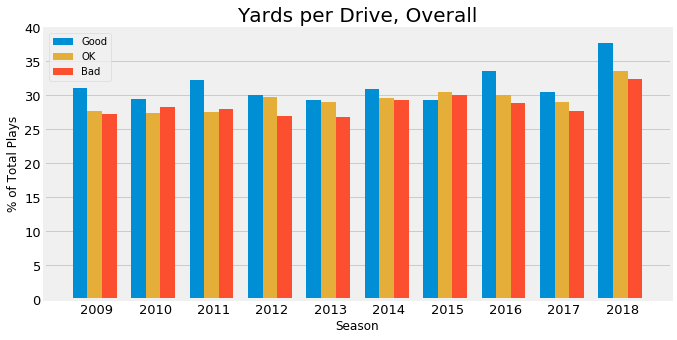

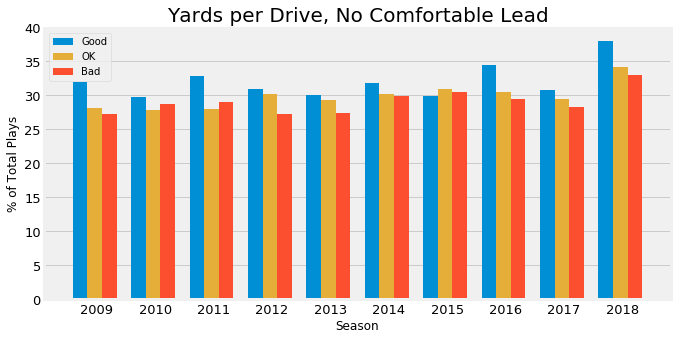

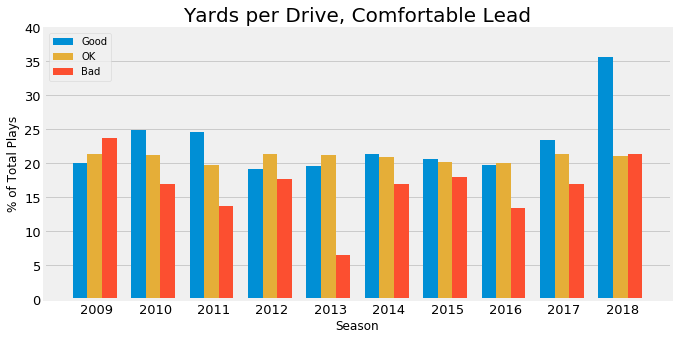

In [28]:
# Yards per drive general formula
def yards_breakdown(df, yards, drives):
    team_list = []
    for season in seasons:
        home_yards = df.loc[(df.season == season) & (df.EOG==1), 'home' + yards].sum()
        away_yards = df.loc[(df.season == season) & (df.EOG==1), 'away' + yards].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_yards = home_yards + away_yards
        total_drives = home_drives + away_drives
        yards_per_drive = total_yards / total_drives
        team_list.append(yards_per_drive)
    return team_list


graphs = ['yards', 'yards_nocl', 'yards_cl']
yards = ['_yards_final', '_yards_wocl_final', '_yards_wcl_final'] 
drives = ['_drives_final', '_drives_wocl_final', '_drives_wcl_final']
titles = ['Yards per Drive, Overall', 'Yards per Drive, No Comfortable Lead', 'Yards per Drive, Comfortable Lead']

for i in range(3):
    good_teams = yards_breakdown(good, yards[i], drives[i])
    ok_teams = yards_breakdown(ok, yards[i], drives[i])
    bad_teams = yards_breakdown(bad, yards[i], drives[i])

    df = pd.DataFrame(
        {
            "Season": seasons,
            "Good": good_teams,
            "OK": ok_teams,
            "Bad": bad_teams
        })

    fig, graphs[i] = plt.subplots(figsize=(10,5))
    graphs[i].bar(df.Season, df.Good, width = .25, color=[0, 143/255, 213/255])
    graphs[i].bar(df.Season + .25, df.OK, width = .25, color=[229/255, 174/255, 56/255])
    graphs[i].bar(df.Season + .5, df.Bad, width = .25, color=[252/255, 79/255, 48/255])
    graphs[i].legend(df[['Good', 'OK', 'Bad']], loc='upper left')
    graphs[i].set_xticklabels(df.Season, fontsize=13, ha='left', rotation=0)
    graphs[i].set_xticks(df.Season)
    graphs[i].set_yticklabels(df.Bad, fontsize=13)
    graphs[i].set_ylim(0, 40)
    graphs[i].xaxis.grid(False)
    graphs[i].set_xlabel('Season')
    graphs[i].set_ylabel('% of Total Plays')
    graphs[i].set_title(titles[i], fontsize=20)
    graphs[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

While there is some separation in overall yards per drive between good teams and bad teams, when a comfortable lead is established, good teams are substantially better at accumulating more yards per drive. While some long-yardage drives can actually be very brief (e.g. drives that result in quick scores on singular explosive plays), they are generally suggestive of longer time of possession. 2018's good teams are also markedly better on this metric when they have comfortable leads.

## Drives per Game

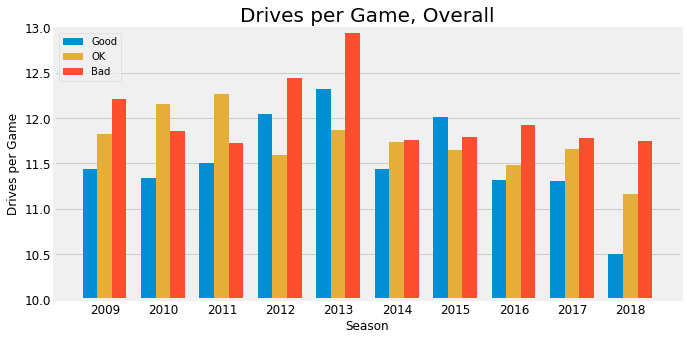

In [29]:
# dpg per drive general formula
def drives_per_game(df, drives):
    team_list = []
    for season in seasons:
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_games = df.loc[(df.season == season) & (df.EOG==1), 'EOG'].count()
        total_drives = home_drives + away_drives
        drives_per_game = total_drives / (total_games * 2)
        team_list.append(drives_per_game)
    return team_list

good_teams_dpg = drives_per_game(good, '_drives_final')
ok_teams_dpg = drives_per_game(ok, '_drives_final')
bad_teams_dpg = drives_per_game(bad, '_drives_final')

%matplotlib inline

dpg = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_dpg,
        "OK": ok_teams_dpg,
        "Bad": bad_teams_dpg
    })

fig, dpg_graph = plt.subplots(figsize=(10,5))

dpg_graph.bar(dpg.Season, dpg.Good, width = .25, color=[0, 143/255, 213/255])
dpg_graph.bar(dpg.Season + .25, dpg.OK, width = .25, color=[229/255, 174/255, 56/255])
dpg_graph.bar(dpg.Season + .5, dpg.Bad, width = .25, color=[252/255, 79/255, 48/255])
dpg_graph.legend(dpg[['Good', 'OK', 'Bad']], loc='upper left')
dpg_graph.set_xticklabels(dpg.Season, fontsize=12, ha='left', rotation=0)
dpg_graph.set_xticks(dpg.Season)
dpg_graph.set_yticklabels(dpg.Good, fontsize=12)
dpg_graph.set_ylim(10, 13)
dpg_graph.xaxis.grid(False)
dpg_graph.set_xlabel('Season')
dpg_graph.set_ylabel('Drives per Game')
dpg_graph.set_title('Drives per Game, Overall', fontsize=20)
dpg_graph.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

Since 2013, all teams have been generating fewer drives per game, but 2018's elite teams truly broke away from the pack by registering only 10.5 drives per game.

## Plays per Drive

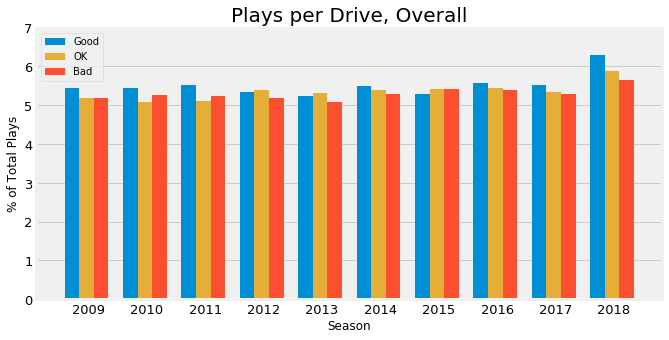

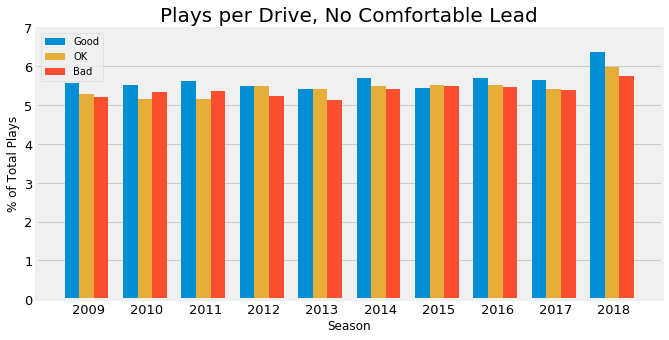

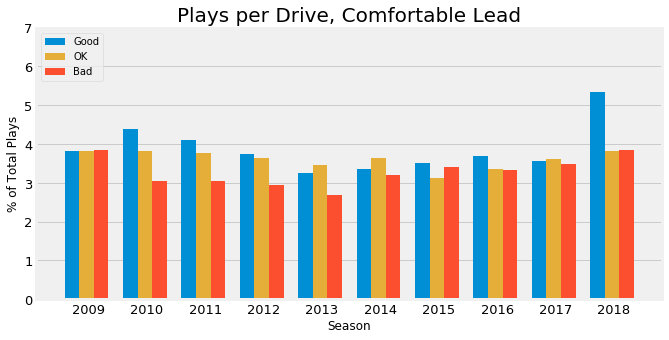

In [30]:
# Plays per drive general formula
def ppd_breakdown(df, plays, drives):
    team_list = []
    for season in seasons:
        home_plays = df.loc[(df.season == season) & (df.EOG==1), 'home' + plays].sum()
        away_plays = df.loc[(df.season == season) & (df.EOG==1), 'away' + plays].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_plays = home_plays + away_plays
        total_drives = home_drives + away_drives
        total_ppd = total_plays / total_drives
        team_list.append(total_ppd)
    return team_list

%matplotlib inline


graphs = ['ppd', 'ppd_nocl', 'ppd_cl']
plays = ['_combined_plays_final', '_combined_plays_wocl_final', '_combined_plays_wcl_final'] 
drives = ['_drives_final', '_drives_wocl_final', '_drives_wcl_final']
titles = ['Plays per Drive, Overall', 'Plays per Drive, No Comfortable Lead', 'Plays per Drive, Comfortable Lead']

for i in range(3):
    good_teams = ppd_breakdown(good, plays[i], drives[i])
    ok_teams = ppd_breakdown(ok, plays[i], drives[i])
    bad_teams = ppd_breakdown(bad, plays[i], drives[i])

    df = pd.DataFrame(
        {
            "Season": seasons,
            "Good": good_teams,
            "OK": ok_teams,
            "Bad": bad_teams
        })

    fig, graphs[i] = plt.subplots(figsize=(10,5))
    graphs[i].bar(df.Season, df.Good, width = .25, color=[0, 143/255, 213/255])
    graphs[i].bar(df.Season + .25, df.OK, width = .25, color=[229/255, 174/255, 56/255])
    graphs[i].bar(df.Season + .5, df.Bad, width = .25, color=[252/255, 79/255, 48/255])
    graphs[i].legend(df[['Good', 'OK', 'Bad']], loc='upper left')
    graphs[i].set_xticklabels(df.Season, fontsize=13, ha='left', rotation=0)
    graphs[i].set_xticks(df.Season)
    graphs[i].set_yticklabels(df.Bad, fontsize=13)
    graphs[i].set_ylim(0, 7)
    graphs[i].xaxis.grid(False)
    graphs[i].set_xlabel('Season')
    graphs[i].set_ylabel('% of Total Plays')
    graphs[i].set_title(titles[i], fontsize=20)
    graphs[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

Again, there is some separation here between good teams and bad teams, and significantly more separation when a comfortable lead is established. We can also see that OK teams in some seasons "punch above their weight" and hit plays per drive levels commensurate with those of good teams.

For the 2018 season, good teams consistently executed 1 more play per drive than other teams when they had comfortable leads.

## TOP per Drive

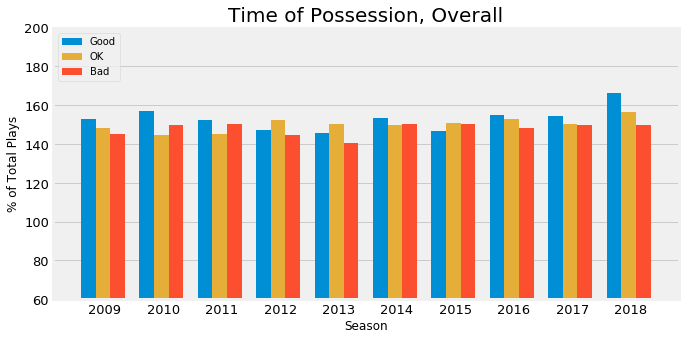

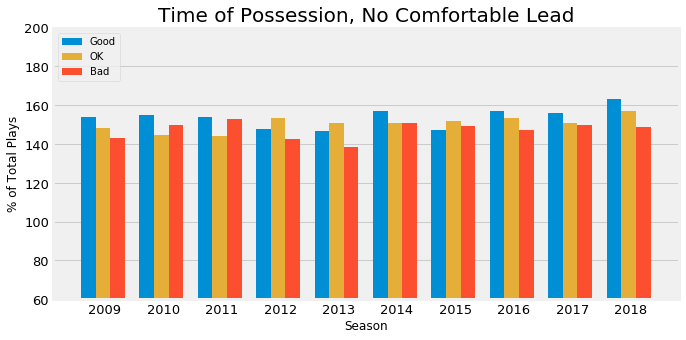

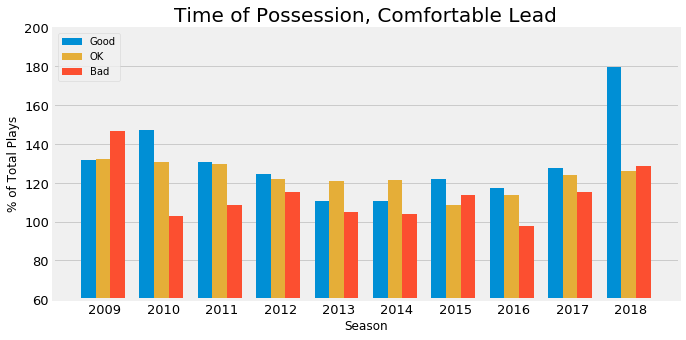

In [31]:
# TOP per drive general formula
def TOP_breakdown(df, TOP, drives):
    team_list = []
    for season in seasons:
        home_TOP = df.loc[(df.season == season) & (df.EOG==1), 'home' + TOP].sum()
        away_TOP = df.loc[(df.season == season) & (df.EOG==1), 'away' + TOP].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_TOP = home_TOP + away_TOP
        total_drives = home_drives + away_drives
        total_TOP_pd = total_TOP / total_drives
        team_list.append(total_TOP_pd)
    return team_list


graphs = ['ppd', 'ppd_nocl', 'ppd_cl']
TOP = ['_TOP_final', '_TOP_wocl_final', '_TOP_wcl_final'] 
drives = ['_drives_final', '_drives_wocl_final', '_drives_wcl_final']
titles = ['Time of Possession, Overall', 'Time of Possession, No Comfortable Lead', 'Time of Possession, Comfortable Lead']

for i in range(3):
    good_teams = TOP_breakdown(good, TOP[i], drives[i])
    ok_teams = TOP_breakdown(ok, TOP[i], drives[i])
    bad_teams = TOP_breakdown(bad, TOP[i], drives[i])

    df = pd.DataFrame(
        {
            "Season": seasons,
            "Good": good_teams,
            "OK": ok_teams,
            "Bad": bad_teams
        })

    fig, graphs[i] = plt.subplots(figsize=(10,5))
    graphs[i].bar(df.Season, df.Good, width = .25, color=[0, 143/255, 213/255])
    graphs[i].bar(df.Season + .25, df.OK, width = .25, color=[229/255, 174/255, 56/255])
    graphs[i].bar(df.Season + .5, df.Bad, width = .25, color=[252/255, 79/255, 48/255])
    graphs[i].legend(df[['Good', 'OK', 'Bad']], loc='upper left')
    graphs[i].set_xticklabels(df.Season, fontsize=13, ha='left', rotation=0)
    graphs[i].set_xticks(df.Season)
    graphs[i].set_yticklabels(df.Bad, fontsize=13)
    graphs[i].set_ylim(60, 200)
    graphs[i].xaxis.grid(False)
    graphs[i].set_xlabel('Season')
    graphs[i].set_ylabel('% of Total Plays')
    graphs[i].set_title(titles[i], fontsize=20)
    graphs[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

This is the most on-the-nose indicator of ball control and a great suggester of offensive efficiency. Good teams overall hold onto the ball longer than bad teams by ~7 seconds per drive. When a comfortable lead is established, good teams are dramatically better at draining the clock. Bad teams surrender the ball faster and blow comfortable leads.

Good teams in 2018 also pushed TOP with a comfortable lead to a new high at 180 seconds.

## Points per Drive

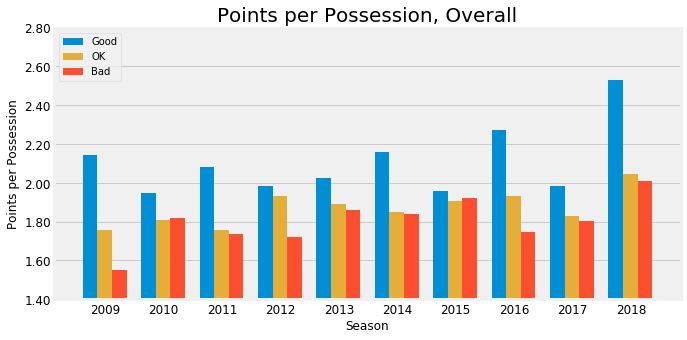

In [32]:
# Points per drive general formula
def score_breakdown(df, score, drives):
    team_list = []
    for season in seasons:
        home_score = df.loc[(df.season == season) & (df.EOG==1), 'home' + score].sum()
        away_score = df.loc[(df.season == season) & (df.EOG==1), 'away' + score].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_score = home_score + away_score
        total_drives = home_drives + away_drives
        total_score_pd = total_score / total_drives
        team_list.append(total_score_pd)
    return team_list


good_teams_score_pd = score_breakdown(good, '_score_final', '_drives_final')
ok_teams_score_pd = score_breakdown(ok, '_score_final', '_drives_final')
bad_teams_score_pd = score_breakdown(bad, '_score_final', '_drives_final')

score = pd.DataFrame(
    {
        "Season": seasons,
        "Good": good_teams_score_pd,
        "OK": ok_teams_score_pd,
        "Bad": bad_teams_score_pd
    })


fig, score_graph = plt.subplots(figsize=(10,5))

score_graph.bar(score.Season, score.Good, width = .25, color=[0, 143/255, 213/255])
score_graph.bar(score.Season + .25, score.OK, width = .25, color=[229/255, 174/255, 56/255])
score_graph.bar(score.Season + .5, score.Bad, width = .25, color=[252/255, 79/255, 48/255])
score_graph.legend(score[['Good', 'OK', 'Bad']], loc='upper left')
score_graph.set_xticklabels(score.Season, fontsize=12, ha='left', rotation=0)
score_graph.set_xticks(score.Season)
score_graph.set_yticklabels(score.Good, fontsize=12)
score_graph.set_ylim(1.4, 2.8)
score_graph.xaxis.grid(False)
score_graph.set_xlabel('Season')
score_graph.set_ylabel('Points per Possession')
score_graph.set_title('Points per Possession, Overall', fontsize=20)
score_graph.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

Naturally, one would expect a team that wins more to score more points per drive. This expectation holds true in our graph.

# CONCLUSION
Looking at the different performance tiers of teams, there is some separation between the good and the bad teams for each offensive efficiency metric. However, in situations when a team has a comfortable lead, the good teams control the ball much more effectively. They do not blow their leads.

## 'Analytics' Adoption
Unlike the MLB and the NBA, whose teams have wholly embraced <i>advanced analytics</i> (the sports world's generally accepted term for data science), NFL teams lag behind a bit. The general consensus in sports media is that teams have used advanced analytics to drive personnel decisions (drafting players, transacting players, and allocating coaching resources), but only a few teams have utilized it to inform gameplan and play-by-play decisions. 2018 may reflect a deeper plunge into advanced analytics, with offensive efficiency metrics during comfortable leads improving very sharply for elite teams.

## Other Things to Explore
- How a team that had a comfortable lead performs after they lose it and whether that team ultimately wins. A team with a 20-point lead at the start of the 4th quarter may allow the opponent to shrink the margin to 8 points near the end of the game. But at that point, the trailing team's efforts are often "too little, too late." Typically, there is insufficient time for the trailing team to win.
- Schemes and formations, though that would require a more robust dataset.